In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder, NucleusDecoder
from utils.processing_utils import *

1 Physical GPUs, 1 Logical GPUs


# Loading data and spliting

In [3]:
data_path = '../processed_data'
mode = 'custom'
all_train = True
if mode=='w2v':
    with open(os.path.join(data_path,'w2v_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='glove':
    with open(os.path.join(data_path,'glove_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='custom':
    with open(os.path.join(data_path,'glove_embeddings_trained_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_trained_cornell.npy'), 'rb') as f:
        missing = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_cornell.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_cornell.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [4]:
missing_idx = [token_mapping[i] for i in missing]

In [5]:
len(data)

83034

In [6]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [7]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [8]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'cameron .'],
 ['cameron .',
  'the thing is cameron i am at the mercy of a particularly hideous breed of loser . my sister . i can not date until she does .'],
 ['the thing is cameron i am at the mercy of a particularly hideous breed of loser . my sister . i can not date until she does .',
  'seems like she could get a date easy enough .']]

In [9]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [10]:
X, y = slice_data(data)

In [11]:
len(X), len(y)

(221365, 221365)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [13]:
len(X_train), len(X_test)

(188160, 33205)

In [14]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None, 
              return_len=False):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  length = len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      if return_len:
          return sent_ids,length+1
      else:
          return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  if return_len:
      return sent_ids, max_len
  else:
      return sent_ids


In [15]:
max_len_tokens = 10

In [16]:
if all_train:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y])
    y_train, len_train = np.array(y_train), np.array(len_train)
else:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
    X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
    X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_train])
    y_test, len_test = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_test])
    y_train, len_train, y_test, len_test  = np.array(y_train), np.array(len_train), np.array(y_test), np.array(len_test)


In [17]:
X_train_dec[0], y_train[0], len_train[0]

(array([    1, 29084, 12833, 26797, 28992, 29605, 25304, 29464,     3,
        12893]),
 array([29084, 12833, 26797, 28992, 29605, 25304, 29464,     3, 12893,
            2]),
 10)

In [18]:
len(X_train_dec)

221365

# Building a model 

In [19]:
final_embeddings.shape

(30004, 100)

In [20]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32),
        )

# Training a model

In [21]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train, len_train))
if not all_train:
    val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test, len_test))
else:
    val_data = None

In [22]:
batch_size = 256
num_epochs = 200
epochs_patience = 10

In [23]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
            experiment_name='cornell')

  0%|          | 0/200 [00:00<?, ?it/s]

Dir models already exists


  0%|          | 1/200 [02:05<6:55:46, 125.36s/it]



Epoch 0 train loss 6.0638 train perplexity 2322.2158


  1%|          | 2/200 [04:00<6:33:26, 119.23s/it]



Epoch 1 train loss 5.3246 train perplexity 211.6156


  2%|▏         | 3/200 [05:55<6:25:02, 117.27s/it]



Epoch 2 train loss 5.0952 train perplexity 168.0223


  2%|▏         | 4/200 [07:50<6:20:04, 116.35s/it]



Epoch 3 train loss 4.9589 train perplexity 146.5627


  2%|▎         | 5/200 [09:45<6:16:46, 115.93s/it]



Epoch 4 train loss 4.8557 train perplexity 132.2254


  3%|▎         | 6/200 [11:40<6:14:05, 115.70s/it]



Epoch 5 train loss 4.7831 train perplexity 122.9100


  4%|▎         | 7/200 [13:35<6:11:40, 115.55s/it]



Epoch 6 train loss 4.7169 train perplexity 115.0552


  4%|▍         | 8/200 [15:31<6:09:26, 115.45s/it]



Epoch 7 train loss 4.6640 train perplexity 109.0046


  4%|▍         | 9/200 [17:26<6:07:19, 115.39s/it]



Epoch 8 train loss 4.6176 train perplexity 103.9077


  5%|▌         | 10/200 [19:21<6:05:15, 115.34s/it]



Epoch 9 train loss 4.5735 train perplexity 99.3657


  6%|▌         | 11/200 [21:16<6:03:11, 115.30s/it]



Epoch 10 train loss 4.5389 train perplexity 95.9209


  6%|▌         | 12/200 [23:12<6:01:12, 115.28s/it]



Epoch 11 train loss 4.5101 train perplexity 93.1920


  6%|▋         | 13/200 [25:07<5:59:16, 115.27s/it]



Epoch 12 train loss 4.4754 train perplexity 89.9243


  7%|▋         | 14/200 [27:02<5:57:20, 115.27s/it]



Epoch 13 train loss 4.4459 train perplexity 87.3825


  8%|▊         | 15/200 [28:57<5:55:25, 115.27s/it]



Epoch 14 train loss 4.4168 train perplexity 84.7593


  8%|▊         | 16/200 [30:53<5:53:29, 115.27s/it]



Epoch 15 train loss 4.3995 train perplexity 83.2780


  8%|▊         | 17/200 [32:48<5:51:35, 115.27s/it]



Epoch 16 train loss 4.3703 train perplexity 80.9346


  9%|▉         | 18/200 [34:43<5:49:39, 115.27s/it]



Epoch 17 train loss 4.3520 train perplexity 79.3052


 10%|▉         | 19/200 [36:38<5:47:43, 115.27s/it]



Epoch 18 train loss 4.3349 train perplexity 78.0040


 10%|█         | 20/200 [38:34<5:45:48, 115.27s/it]



Epoch 19 train loss 4.3143 train perplexity 76.3106


 10%|█         | 21/200 [40:29<5:43:52, 115.27s/it]



Epoch 20 train loss 4.2920 train perplexity 74.6625


 11%|█         | 22/200 [42:24<5:41:57, 115.27s/it]



Epoch 21 train loss 4.2766 train perplexity 73.4482


 12%|█▏        | 23/200 [44:19<5:40:02, 115.27s/it]



Epoch 22 train loss 4.2618 train perplexity 72.3524


 12%|█▏        | 24/200 [46:15<5:38:06, 115.26s/it]



Epoch 23 train loss 4.2461 train perplexity 71.1938


 12%|█▎        | 25/200 [48:10<5:36:11, 115.26s/it]



Epoch 24 train loss 4.2296 train perplexity 70.0196


 13%|█▎        | 26/200 [50:05<5:34:14, 115.26s/it]



Epoch 25 train loss 4.2147 train perplexity 69.0337


 14%|█▎        | 27/200 [52:00<5:32:20, 115.26s/it]



Epoch 26 train loss 4.2060 train perplexity 68.3782


 14%|█▍        | 28/200 [53:56<5:30:25, 115.26s/it]



Epoch 27 train loss 4.1851 train perplexity 66.9878


 14%|█▍        | 29/200 [55:51<5:28:31, 115.27s/it]



Epoch 28 train loss 4.1749 train perplexity 66.2999


 15%|█▌        | 30/200 [57:46<5:26:36, 115.27s/it]



Epoch 29 train loss 4.1605 train perplexity 65.2707


 16%|█▌        | 31/200 [59:42<5:24:39, 115.27s/it]



Epoch 30 train loss 4.1505 train perplexity 64.6069


 16%|█▌        | 32/200 [1:01:37<5:22:46, 115.27s/it]



Epoch 31 train loss 4.1367 train perplexity 63.7102


 16%|█▋        | 33/200 [1:03:32<5:20:50, 115.27s/it]



Epoch 32 train loss 4.1264 train perplexity 63.0566


 17%|█▋        | 34/200 [1:05:27<5:18:56, 115.28s/it]



Epoch 33 train loss 4.1137 train perplexity 62.2964


 18%|█▊        | 35/200 [1:07:23<5:17:00, 115.27s/it]



Epoch 34 train loss 4.1024 train perplexity 61.4953


 18%|█▊        | 36/200 [1:09:18<5:15:05, 115.28s/it]



Epoch 35 train loss 4.0973 train perplexity 61.1905


 18%|█▊        | 37/200 [1:11:13<5:13:09, 115.28s/it]



Epoch 36 train loss 4.0830 train perplexity 60.3467


 19%|█▉        | 38/200 [1:13:09<5:11:13, 115.27s/it]



Epoch 37 train loss 4.0744 train perplexity 59.8728


 20%|█▉        | 39/200 [1:15:04<5:09:19, 115.28s/it]



Epoch 38 train loss 4.0665 train perplexity 59.3246


 20%|██        | 40/200 [1:16:59<5:07:24, 115.28s/it]



Epoch 39 train loss 4.0607 train perplexity 59.0566


 20%|██        | 41/200 [1:18:54<5:05:28, 115.27s/it]



Epoch 40 train loss 4.0448 train perplexity 57.9838


 21%|██        | 42/200 [1:20:50<5:03:32, 115.27s/it]



Epoch 41 train loss 4.0367 train perplexity 57.5582


 22%|██▏       | 43/200 [1:22:45<5:01:37, 115.27s/it]



Epoch 42 train loss 4.0280 train perplexity 57.0390


 22%|██▏       | 44/200 [1:24:40<4:59:41, 115.26s/it]



Epoch 43 train loss 4.0174 train perplexity 56.4958


 22%|██▎       | 45/200 [1:26:35<4:57:45, 115.26s/it]



Epoch 44 train loss 4.0136 train perplexity 56.2352


 23%|██▎       | 46/200 [1:28:31<4:55:50, 115.26s/it]



Epoch 45 train loss 4.0040 train perplexity 55.7015


 24%|██▎       | 47/200 [1:30:26<4:54:05, 115.33s/it]



Epoch 46 train loss 3.9955 train perplexity 55.2402


 24%|██▍       | 48/200 [1:32:21<4:52:06, 115.31s/it]



Epoch 47 train loss 3.9894 train perplexity 54.9023


 24%|██▍       | 49/200 [1:34:17<4:50:09, 115.30s/it]



Epoch 48 train loss 3.9779 train perplexity 54.2253


 25%|██▌       | 50/200 [1:36:12<4:48:14, 115.30s/it]



Epoch 49 train loss 3.9747 train perplexity 54.0672


 26%|██▌       | 51/200 [1:38:07<4:46:19, 115.30s/it]



Epoch 50 train loss 3.9626 train perplexity 53.4036


 26%|██▌       | 52/200 [1:40:03<4:44:23, 115.30s/it]



Epoch 51 train loss 3.9567 train perplexity 53.1014


 26%|██▋       | 53/200 [1:41:58<4:42:28, 115.29s/it]



Epoch 52 train loss 3.9513 train perplexity 52.7632


 27%|██▋       | 54/200 [1:43:53<4:40:33, 115.30s/it]



Epoch 53 train loss 3.9433 train perplexity 52.3731


 28%|██▊       | 55/200 [1:45:48<4:38:37, 115.29s/it]



Epoch 54 train loss 3.9412 train perplexity 52.2990


 28%|██▊       | 56/200 [1:47:44<4:36:42, 115.30s/it]



Epoch 55 train loss 3.9359 train perplexity 51.9807


 28%|██▊       | 57/200 [1:49:39<4:34:47, 115.30s/it]



Epoch 56 train loss 3.9214 train perplexity 51.2091


 29%|██▉       | 58/200 [1:51:34<4:32:53, 115.30s/it]



Epoch 57 train loss 3.9164 train perplexity 50.9305


 30%|██▉       | 59/200 [1:53:30<4:30:56, 115.30s/it]



Epoch 58 train loss 3.9144 train perplexity 50.7963


 30%|███       | 60/200 [1:55:25<4:29:01, 115.29s/it]



Epoch 59 train loss 3.9080 train perplexity 50.4753


 30%|███       | 61/200 [1:57:20<4:27:06, 115.30s/it]



Epoch 60 train loss 3.9016 train perplexity 50.2060


 31%|███       | 62/200 [1:59:15<4:25:08, 115.28s/it]



Epoch 61 train loss 3.8985 train perplexity 50.0553


 32%|███▏      | 63/200 [2:01:11<4:23:12, 115.28s/it]



Epoch 62 train loss 3.8897 train perplexity 49.5984


 32%|███▏      | 64/200 [2:03:06<4:21:17, 115.28s/it]



Epoch 63 train loss 3.8847 train perplexity 49.3262


 32%|███▎      | 65/200 [2:05:01<4:19:22, 115.27s/it]



Epoch 64 train loss 3.8806 train perplexity 49.1104


 33%|███▎      | 66/200 [2:06:57<4:17:26, 115.27s/it]



Epoch 65 train loss 3.8725 train perplexity 48.7823


 34%|███▎      | 67/200 [2:08:52<4:15:33, 115.29s/it]



Epoch 66 train loss 3.8693 train perplexity 48.5719


 34%|███▍      | 68/200 [2:10:47<4:13:39, 115.30s/it]



Epoch 67 train loss 3.8649 train perplexity 48.3738


 34%|███▍      | 69/200 [2:12:43<4:11:44, 115.30s/it]



Epoch 68 train loss 3.8621 train perplexity 48.2263


 35%|███▌      | 70/200 [2:14:38<4:09:49, 115.30s/it]



Epoch 69 train loss 3.8534 train perplexity 47.7706


 36%|███▌      | 71/200 [2:16:33<4:07:53, 115.30s/it]



Epoch 70 train loss 3.8493 train perplexity 47.5982


 36%|███▌      | 72/200 [2:18:28<4:05:57, 115.29s/it]



Epoch 71 train loss 3.8452 train perplexity 47.3880


 36%|███▋      | 73/200 [2:20:24<4:04:01, 115.29s/it]



Epoch 72 train loss 3.8414 train perplexity 47.2009


 37%|███▋      | 74/200 [2:22:19<4:02:05, 115.28s/it]



Epoch 73 train loss 3.8383 train perplexity 47.0806


 38%|███▊      | 75/200 [2:24:14<4:00:10, 115.28s/it]



Epoch 74 train loss 3.8333 train perplexity 46.8380


 38%|███▊      | 76/200 [2:26:10<3:58:17, 115.30s/it]



Epoch 75 train loss 3.8261 train perplexity 46.5090


 38%|███▊      | 77/200 [2:28:05<3:56:21, 115.30s/it]



Epoch 76 train loss 3.8279 train perplexity 46.5930


 39%|███▉      | 78/200 [2:30:00<3:54:26, 115.30s/it]



Epoch 77 train loss 3.8192 train perplexity 46.1496


 40%|███▉      | 79/200 [2:31:55<3:52:30, 115.30s/it]



Epoch 78 train loss 3.8160 train perplexity 46.0328


 40%|████      | 80/200 [2:33:51<3:50:34, 115.29s/it]



Epoch 79 train loss 3.8166 train perplexity 46.0905


 40%|████      | 81/200 [2:35:48<3:49:33, 115.74s/it]



Epoch 80 train loss 3.8099 train perplexity 45.7609


 41%|████      | 82/200 [2:37:45<3:48:26, 116.15s/it]



Epoch 81 train loss 3.8047 train perplexity 45.4953


 42%|████▏     | 83/200 [2:39:43<3:47:53, 116.87s/it]



Epoch 82 train loss 3.8025 train perplexity 45.4103


 42%|████▏     | 84/200 [2:41:42<3:47:08, 117.48s/it]



Epoch 83 train loss 3.7976 train perplexity 45.1884


 42%|████▎     | 85/200 [2:43:39<3:44:54, 117.34s/it]



Epoch 84 train loss 3.7945 train perplexity 45.0226


 43%|████▎     | 86/200 [2:45:38<3:43:56, 117.86s/it]



Epoch 85 train loss 3.7909 train perplexity 44.8480


 44%|████▎     | 87/200 [2:47:36<3:41:40, 117.70s/it]



Epoch 86 train loss 3.7861 train perplexity 44.6782


 44%|████▍     | 88/200 [2:49:33<3:39:41, 117.70s/it]



Epoch 87 train loss 3.7861 train perplexity 44.6557


 44%|████▍     | 89/200 [2:51:30<3:37:25, 117.53s/it]



Epoch 88 train loss 3.7838 train perplexity 44.5312


 45%|████▌     | 90/200 [2:53:27<3:35:09, 117.36s/it]



Epoch 89 train loss 3.7773 train perplexity 44.2671


 46%|████▌     | 91/200 [2:55:25<3:33:23, 117.46s/it]



Epoch 90 train loss 3.7779 train perplexity 44.2739


 46%|████▌     | 92/200 [2:57:22<3:31:27, 117.47s/it]



Epoch 91 train loss 3.7747 train perplexity 44.1507


 46%|████▋     | 93/200 [2:59:19<3:28:45, 117.06s/it]



Epoch 92 train loss 3.7711 train perplexity 44.0033


 47%|████▋     | 94/200 [3:01:14<3:25:58, 116.59s/it]



Epoch 93 train loss 3.7651 train perplexity 43.7126


 48%|████▊     | 95/200 [3:03:10<3:23:34, 116.33s/it]



Epoch 94 train loss 3.7622 train perplexity 43.5610


 48%|████▊     | 96/200 [3:05:07<3:21:58, 116.52s/it]



Epoch 95 train loss 3.7629 train perplexity 43.6486


 48%|████▊     | 97/200 [3:07:04<3:20:14, 116.64s/it]



Epoch 96 train loss 3.7607 train perplexity 43.5327


 49%|████▉     | 98/200 [3:08:59<3:17:49, 116.37s/it]



Epoch 97 train loss 3.7586 train perplexity 43.4495


 50%|████▉     | 99/200 [3:10:57<3:16:39, 116.83s/it]



Epoch 98 train loss 3.7550 train perplexity 43.2740


 50%|█████     | 100/200 [3:12:54<3:14:46, 116.86s/it]



Epoch 99 train loss 3.7491 train perplexity 42.9918


 50%|█████     | 101/200 [3:14:50<3:12:01, 116.38s/it]



Epoch 100 train loss 3.7505 train perplexity 43.0783


 51%|█████     | 102/200 [3:16:45<3:09:35, 116.07s/it]



Epoch 101 train loss 3.7488 train perplexity 43.0152


 52%|█████▏    | 103/200 [3:18:40<3:07:19, 115.87s/it]



Epoch 102 train loss 3.7441 train perplexity 42.8225


 52%|█████▏    | 104/200 [3:20:36<3:05:14, 115.78s/it]



Epoch 103 train loss 3.7441 train perplexity 42.8003


 52%|█████▎    | 105/200 [3:22:31<3:03:14, 115.73s/it]



Epoch 104 train loss 3.7425 train perplexity 42.7103


 53%|█████▎    | 106/200 [3:24:27<3:01:12, 115.66s/it]



Epoch 105 train loss 3.7368 train perplexity 42.5019


 54%|█████▎    | 107/200 [3:26:23<2:59:37, 115.88s/it]



Epoch 106 train loss 3.7380 train perplexity 42.5702


 54%|█████▍    | 108/200 [3:28:19<2:57:30, 115.76s/it]



Epoch 107 train loss 3.7366 train perplexity 42.4861


 55%|█████▍    | 109/200 [3:30:14<2:55:25, 115.66s/it]



Epoch 108 train loss 3.7355 train perplexity 42.4332


 55%|█████▌    | 110/200 [3:32:10<2:53:27, 115.64s/it]



Epoch 109 train loss 3.7275 train perplexity 42.0995


 56%|█████▌    | 111/200 [3:34:05<2:51:26, 115.58s/it]



Epoch 110 train loss 3.7300 train perplexity 42.2088


 56%|█████▌    | 112/200 [3:36:01<2:49:29, 115.56s/it]



Epoch 111 train loss 3.7262 train perplexity 42.0180


 56%|█████▋    | 113/200 [3:37:56<2:47:30, 115.53s/it]



Epoch 112 train loss 3.7230 train perplexity 41.9286


 57%|█████▋    | 114/200 [3:39:52<2:45:36, 115.54s/it]



Epoch 113 train loss 3.7233 train perplexity 41.9322


 57%|█████▊    | 115/200 [3:41:47<2:43:38, 115.51s/it]



Epoch 114 train loss 3.7227 train perplexity 41.8901


 58%|█████▊    | 116/200 [3:43:43<2:41:43, 115.51s/it]



Epoch 115 train loss 3.7158 train perplexity 41.6228


 58%|█████▊    | 117/200 [3:45:38<2:39:49, 115.53s/it]



Epoch 116 train loss 3.7161 train perplexity 41.6011


 59%|█████▉    | 118/200 [3:47:34<2:37:53, 115.53s/it]



Epoch 117 train loss 3.7106 train perplexity 41.3614


 60%|█████▉    | 119/200 [3:49:29<2:35:58, 115.53s/it]



Epoch 118 train loss 3.7134 train perplexity 41.4770


 60%|██████    | 120/200 [3:51:25<2:34:03, 115.54s/it]



Epoch 119 train loss 3.7125 train perplexity 41.4546


 60%|██████    | 121/200 [3:53:21<2:32:11, 115.58s/it]



Epoch 120 train loss 3.7123 train perplexity 41.4280


 61%|██████    | 122/200 [3:55:16<2:30:14, 115.58s/it]



Epoch 121 train loss 3.7088 train perplexity 41.3058


 62%|██████▏   | 123/200 [3:57:12<2:28:18, 115.57s/it]



Epoch 122 train loss 3.7107 train perplexity 41.4081


 62%|██████▏   | 124/200 [3:59:07<2:26:22, 115.56s/it]



Epoch 123 train loss 3.7082 train perplexity 41.2579


 62%|██████▎   | 125/200 [4:01:03<2:24:27, 115.57s/it]



Epoch 124 train loss 3.7024 train perplexity 41.0502


 63%|██████▎   | 126/200 [4:02:58<2:22:30, 115.55s/it]



Epoch 125 train loss 3.7090 train perplexity 41.3340


 64%|██████▎   | 127/200 [4:04:54<2:20:35, 115.56s/it]



Epoch 126 train loss 3.7026 train perplexity 41.0417


 64%|██████▍   | 128/200 [4:06:50<2:18:41, 115.58s/it]



Epoch 127 train loss 3.7000 train perplexity 40.9299


 64%|██████▍   | 129/200 [4:08:45<2:16:45, 115.57s/it]



Epoch 128 train loss 3.6941 train perplexity 40.6950


 65%|██████▌   | 130/200 [4:10:41<2:14:50, 115.58s/it]



Epoch 129 train loss 3.6962 train perplexity 40.7756


 66%|██████▌   | 131/200 [4:12:36<2:12:54, 115.57s/it]



Epoch 130 train loss 3.6924 train perplexity 40.6258


 66%|██████▌   | 132/200 [4:14:32<2:11:00, 115.60s/it]



Epoch 131 train loss 3.6936 train perplexity 40.6456


 66%|██████▋   | 133/200 [4:16:28<2:09:05, 115.61s/it]



Epoch 132 train loss 3.6944 train perplexity 40.6932


 67%|██████▋   | 134/200 [4:18:23<2:07:10, 115.61s/it]



Epoch 133 train loss 3.6935 train perplexity 40.6730


 68%|██████▊   | 135/200 [4:20:19<2:05:15, 115.62s/it]



Epoch 134 train loss 3.6877 train perplexity 40.4486


 68%|██████▊   | 136/200 [4:22:14<2:03:19, 115.62s/it]



Epoch 135 train loss 3.6879 train perplexity 40.4308


 68%|██████▊   | 137/200 [4:24:10<2:01:22, 115.60s/it]



Epoch 136 train loss 3.6898 train perplexity 40.5141


 69%|██████▉   | 138/200 [4:26:06<1:59:27, 115.60s/it]



Epoch 137 train loss 3.6812 train perplexity 40.1453


 70%|██████▉   | 139/200 [4:28:01<1:57:31, 115.59s/it]



Epoch 138 train loss 3.6892 train perplexity 40.4811


 70%|███████   | 140/200 [4:29:57<1:55:36, 115.60s/it]



Epoch 139 train loss 3.6820 train perplexity 40.2023


 70%|███████   | 141/200 [4:31:52<1:53:40, 115.60s/it]



Epoch 140 train loss 3.6813 train perplexity 40.1476


 71%|███████   | 142/200 [4:33:48<1:51:45, 115.62s/it]



Epoch 141 train loss 3.6808 train perplexity 40.1460


 72%|███████▏  | 143/200 [4:35:44<1:49:48, 115.60s/it]



Epoch 142 train loss 3.6808 train perplexity 40.1452


 72%|███████▏  | 144/200 [4:37:39<1:47:53, 115.61s/it]



Epoch 143 train loss 3.6757 train perplexity 39.9355


 72%|███████▎  | 145/200 [4:39:35<1:45:59, 115.63s/it]



Epoch 144 train loss 3.6784 train perplexity 40.0481


 73%|███████▎  | 146/200 [4:41:31<1:44:08, 115.72s/it]



Epoch 145 train loss 3.6779 train perplexity 40.0051


 74%|███████▎  | 147/200 [4:43:27<1:42:11, 115.69s/it]



Epoch 146 train loss 3.6717 train perplexity 39.7689


 74%|███████▍  | 148/200 [4:45:22<1:40:14, 115.65s/it]



Epoch 147 train loss 3.6708 train perplexity 39.7323


 74%|███████▍  | 149/200 [4:47:18<1:38:17, 115.64s/it]



Epoch 148 train loss 3.6711 train perplexity 39.7474


 75%|███████▌  | 150/200 [4:49:13<1:36:21, 115.64s/it]



Epoch 149 train loss 3.6714 train perplexity 39.7406


 76%|███████▌  | 151/200 [4:51:09<1:34:26, 115.64s/it]



Epoch 150 train loss 3.6743 train perplexity 39.8988


 76%|███████▌  | 152/200 [4:53:05<1:32:30, 115.63s/it]



Epoch 151 train loss 3.6741 train perplexity 39.8723


 76%|███████▋  | 153/200 [4:55:00<1:30:34, 115.63s/it]



Epoch 152 train loss 3.6678 train perplexity 39.6314


 77%|███████▋  | 154/200 [4:56:56<1:28:38, 115.61s/it]



Epoch 153 train loss 3.6649 train perplexity 39.5156


 78%|███████▊  | 155/200 [4:58:51<1:26:43, 115.64s/it]



Epoch 154 train loss 3.6602 train perplexity 39.3061


 78%|███████▊  | 156/200 [5:00:47<1:24:48, 115.64s/it]



Epoch 155 train loss 3.6670 train perplexity 39.5747


 78%|███████▊  | 157/200 [5:02:43<1:22:51, 115.63s/it]



Epoch 156 train loss 3.6644 train perplexity 39.5108


 79%|███████▉  | 158/200 [5:04:38<1:20:56, 115.64s/it]



Epoch 157 train loss 3.6605 train perplexity 39.3460


 80%|███████▉  | 159/200 [5:06:34<1:19:02, 115.66s/it]



Epoch 158 train loss 3.6604 train perplexity 39.3218


 80%|████████  | 160/200 [5:08:30<1:17:07, 115.69s/it]



Epoch 159 train loss 3.6578 train perplexity 39.2111


 80%|████████  | 161/200 [5:10:25<1:15:11, 115.68s/it]



Epoch 160 train loss 3.6619 train perplexity 39.3795


 81%|████████  | 162/200 [5:12:21<1:13:16, 115.69s/it]



Epoch 161 train loss 3.6579 train perplexity 39.2246


 82%|████████▏ | 163/200 [5:14:17<1:11:22, 115.73s/it]



Epoch 162 train loss 3.6567 train perplexity 39.1826


 82%|████████▏ | 164/200 [5:16:13<1:09:26, 115.74s/it]



Epoch 163 train loss 3.6539 train perplexity 39.0882


 82%|████████▎ | 165/200 [5:18:09<1:07:30, 115.74s/it]



Epoch 164 train loss 3.6541 train perplexity 39.0731


 83%|████████▎ | 166/200 [5:20:04<1:05:34, 115.71s/it]



Epoch 165 train loss 3.6592 train perplexity 39.2993


 84%|████████▎ | 167/200 [5:22:00<1:03:38, 115.72s/it]



Epoch 166 train loss 3.6521 train perplexity 39.0095


 84%|████████▍ | 168/200 [5:23:57<1:01:56, 116.14s/it]



Epoch 167 train loss 3.6484 train perplexity 38.8644


 84%|████████▍ | 169/200 [5:25:53<1:00:02, 116.20s/it]



Epoch 168 train loss 3.6543 train perplexity 39.0626


 85%|████████▌ | 170/200 [5:27:49<58:03, 116.10s/it]  



Epoch 169 train loss 3.6577 train perplexity 39.2074


 86%|████████▌ | 171/200 [5:29:45<56:03, 116.00s/it]



Epoch 170 train loss 3.6501 train perplexity 38.9318


 86%|████████▌ | 172/200 [5:31:41<54:10, 116.08s/it]



Epoch 171 train loss 3.6493 train perplexity 38.8923


 86%|████████▋ | 173/200 [5:33:37<52:13, 116.07s/it]



Epoch 172 train loss 3.6458 train perplexity 38.7797


 87%|████████▋ | 174/200 [5:35:34<50:22, 116.24s/it]



Epoch 173 train loss 3.6484 train perplexity 38.8519


 88%|████████▊ | 175/200 [5:37:30<48:22, 116.10s/it]



Epoch 174 train loss 3.6451 train perplexity 38.7295


 88%|████████▊ | 176/200 [5:39:26<46:30, 116.29s/it]



Epoch 175 train loss 3.6414 train perplexity 38.6015


 88%|████████▊ | 177/200 [5:41:22<44:32, 116.21s/it]



Epoch 176 train loss 3.6399 train perplexity 38.5270


 89%|████████▉ | 178/200 [5:43:19<42:38, 116.28s/it]



Epoch 177 train loss 3.6452 train perplexity 38.7211


 90%|████████▉ | 179/200 [5:45:15<40:38, 116.11s/it]



Epoch 178 train loss 3.6424 train perplexity 38.6387


 90%|█████████ | 180/200 [5:47:10<38:39, 115.98s/it]



Epoch 179 train loss 3.6388 train perplexity 38.5170


 90%|█████████ | 181/200 [5:49:06<36:42, 115.90s/it]



Epoch 180 train loss 3.6415 train perplexity 38.5876


 91%|█████████ | 182/200 [5:51:04<34:59, 116.64s/it]



Epoch 181 train loss 3.6400 train perplexity 38.5147


 92%|█████████▏| 183/200 [5:53:01<33:02, 116.60s/it]



Epoch 182 train loss 3.6352 train perplexity 38.3520


 92%|█████████▏| 184/200 [5:54:57<31:01, 116.34s/it]



Epoch 183 train loss 3.6369 train perplexity 38.3946


 92%|█████████▎| 185/200 [5:56:53<29:03, 116.22s/it]



Epoch 184 train loss 3.6310 train perplexity 38.1855


 93%|█████████▎| 186/200 [5:58:48<27:05, 116.09s/it]



Epoch 185 train loss 3.6344 train perplexity 38.3259


 94%|█████████▎| 187/200 [6:00:48<25:21, 117.04s/it]



Epoch 186 train loss 3.6312 train perplexity 38.1659


 94%|█████████▍| 188/200 [6:02:48<23:34, 117.91s/it]



Epoch 187 train loss 3.6282 train perplexity 38.1020


 94%|█████████▍| 189/200 [6:04:47<21:41, 118.32s/it]



Epoch 188 train loss 3.6303 train perplexity 38.1584


 95%|█████████▌| 190/200 [6:06:43<19:37, 117.70s/it]



Epoch 189 train loss 3.6296 train perplexity 38.1378


 96%|█████████▌| 191/200 [6:08:39<17:35, 117.28s/it]



Epoch 190 train loss 3.6357 train perplexity 38.3717


 96%|█████████▌| 192/200 [6:10:36<15:35, 116.95s/it]



Epoch 191 train loss 3.6296 train perplexity 38.1216


 96%|█████████▋| 193/200 [6:12:33<13:40, 117.16s/it]



Epoch 192 train loss 3.6322 train perplexity 38.2164


 97%|█████████▋| 194/200 [6:14:33<11:47, 117.84s/it]



Epoch 193 train loss 3.6291 train perplexity 38.1259


 98%|█████████▊| 195/200 [6:16:31<09:49, 117.93s/it]



Epoch 194 train loss 3.6280 train perplexity 38.0634


 98%|█████████▊| 196/200 [6:18:29<07:51, 117.97s/it]



Epoch 195 train loss 3.6248 train perplexity 37.9415


 98%|█████████▊| 197/200 [6:20:25<05:52, 117.48s/it]



Epoch 196 train loss 3.6297 train perplexity 38.1412


 99%|█████████▉| 198/200 [6:22:21<03:53, 116.96s/it]



Epoch 197 train loss 3.6238 train perplexity 37.9154


100%|█████████▉| 199/200 [6:24:19<01:57, 117.40s/it]



Epoch 198 train loss 3.6229 train perplexity 37.8755


100%|██████████| 200/200 [6:26:16<00:00, 115.88s/it]



Epoch 199 train loss 3.6232 train perplexity 37.8906
Finished training


In [24]:
seq2seq.save_models(decoder_path='decoder_all_data_cornell.h5',
                   encoder_path='encoder_all_data_cornell.h5')

# Testing predictions and other helpful stuff

In [25]:
from utils.model_utils import plot_attention

In [26]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [27]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
              top_p=0.95,
               beam_search=False,
               nucleus_sampling = False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      elif nucleus_sampling:
        prediction = decoder.decode(mapped_sentence, len_output, top_p)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [28]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

../utils/model_utils.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
../utils/model_utils.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


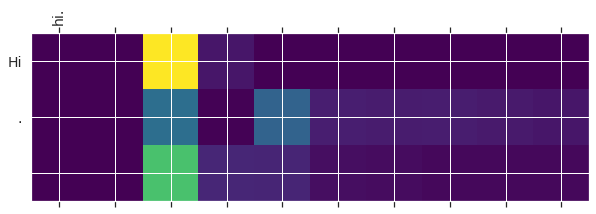

'Hi .'

In [29]:
give_answer(greedy_decoder, 'hi. ', inverse_token_mapping, show_attention=True)

In [30]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [32]:
give_answer(beam_search_decoder, 'hi', inverse_token_mapping, show_attention=False,
           beam_search=True)

'I do not know .'

In [33]:
nucleus_decoder = NucleusDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [34]:
give_answer(nucleus_decoder, 'hi', inverse_token_mapping, nucleus_sampling=True, top_p=0.75)

'Lets hope what is a semi answer more or'

# Dialogue generation and question answering

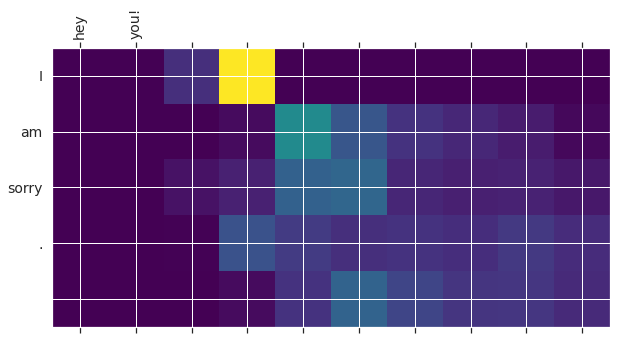

------------------------------
Test replica : hey you!
Bot greedy answer : I am sorry .
Bot beam search answer : Hi .
Bot nucleus answr : Thank you love it . i can not say
------------------------------


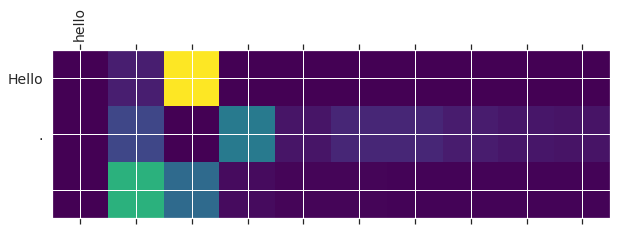

------------------------------
Test replica : hello
Bot greedy answer : Hello .
Bot beam search answer : Hi .
Bot nucleus answr : Hello what what . i really mean i was
------------------------------


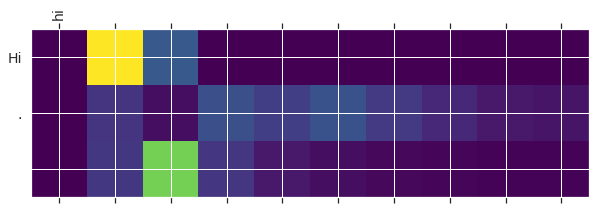

------------------------------
Test replica : hi
Bot greedy answer : Hi .
Bot beam search answer : I do not know .
Bot nucleus answr : Pulling that dirt doyle . do not i tell ?
------------------------------


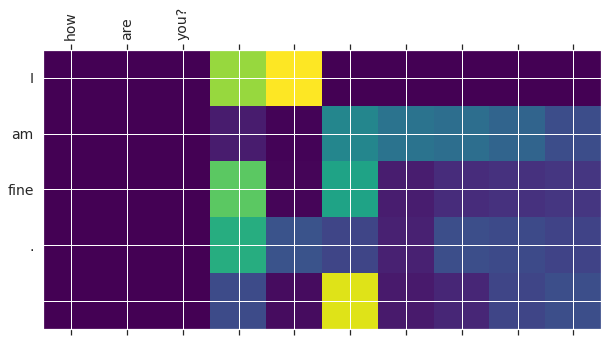

------------------------------
Test replica : how are you?
Bot greedy answer : I am fine .
Bot beam search answer : Hello .
Bot nucleus answr : Scarred but . i guess we would be better
------------------------------


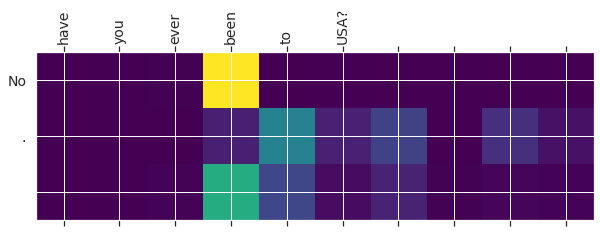

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : No .
Bot beam search answer : Yes .
Bot nucleus answr : That
------------------------------


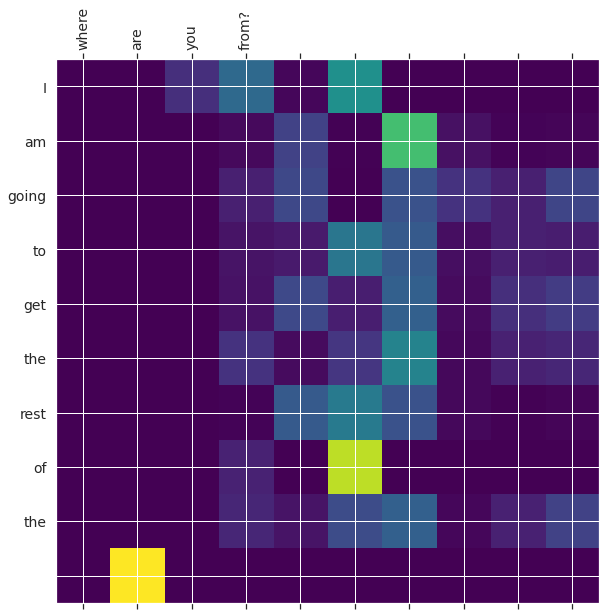

------------------------------
Test replica : where are you from?
Bot greedy answer : I am going to get the rest of the
Bot beam search answer : I do not know .
Bot nucleus answr : A carpet eye from remains .
------------------------------


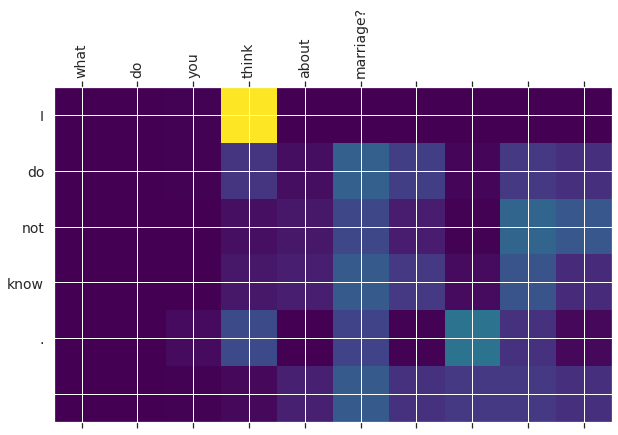

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know .
Bot nucleus answr : <unk> of course they can
------------------------------


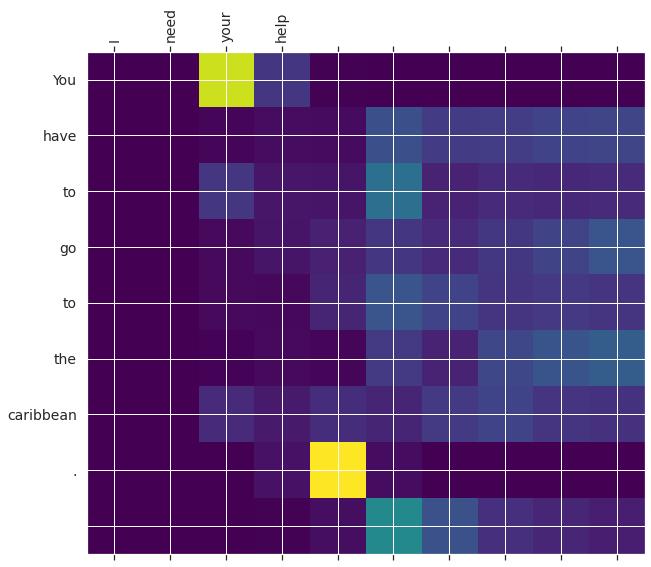

------------------------------
Test replica : I need your help
Bot greedy answer : You have to go to the caribbean .
Bot beam search answer : It is all right .
Bot nucleus answr : We can make some an campaign card
------------------------------


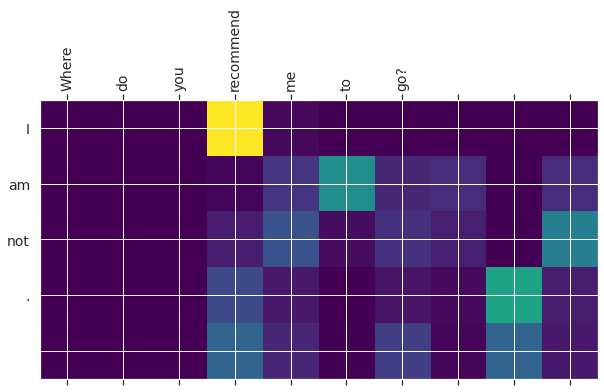

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I am not .
Bot beam search answer : Italy .
Bot nucleus answr : Like all this reminds betrayal they live together in
------------------------------


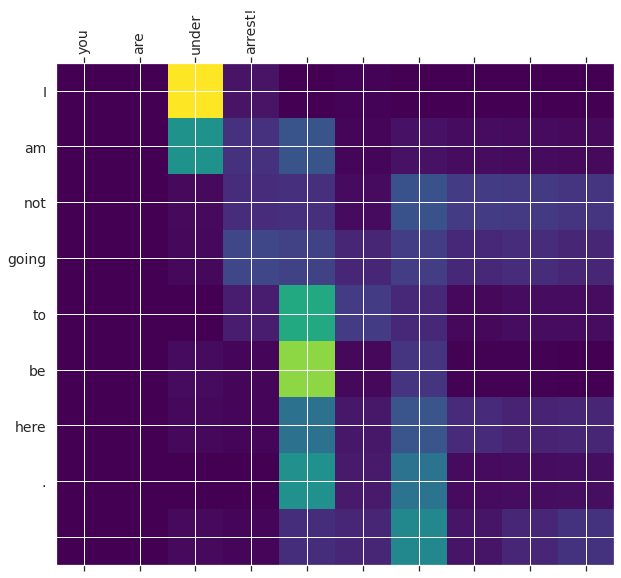

------------------------------
Test replica : you are under arrest!
Bot greedy answer : I am not going to be here .
Bot beam search answer : I do not want to hurt you .
Bot nucleus answr : Go for it !
------------------------------


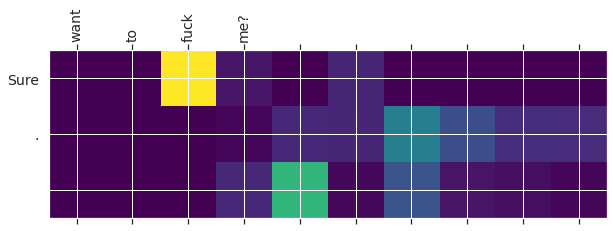

------------------------------
Test replica : want to fuck me?
Bot greedy answer : Sure .
Bot beam search answer : Sure .
Bot nucleus answr : Stop ?
------------------------------


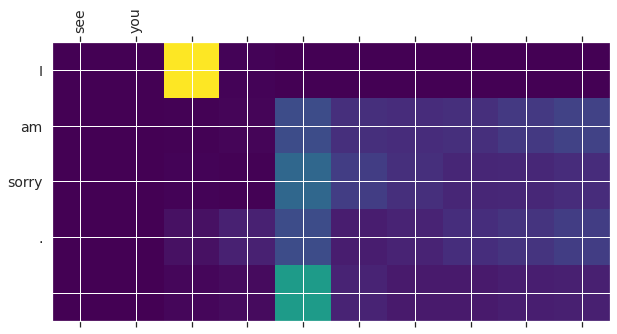

------------------------------
Test replica : see you
Bot greedy answer : I am sorry .
Bot beam search answer : I do not know . i am thx .
Bot nucleus answr : . watching me the bottom . carlotta called me
------------------------------


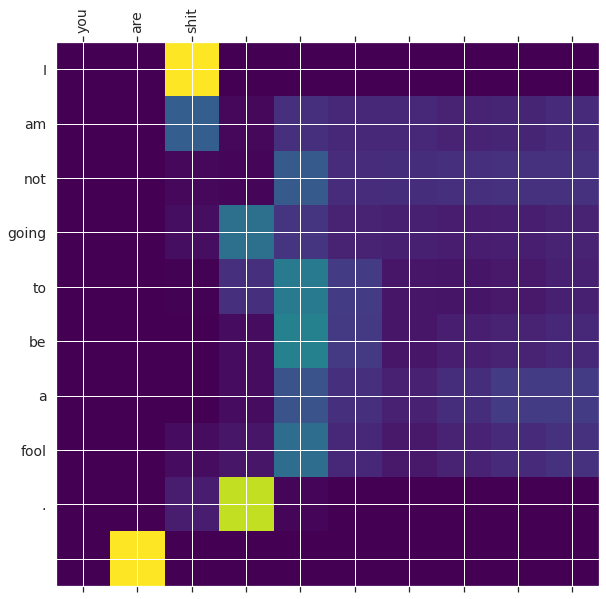

------------------------------
Test replica : you are shit
Bot greedy answer : I am not going to be a fool .
Bot beam search answer : No i am serious .
Bot nucleus answr : Yeah i have not tried her . but i
------------------------------


In [35]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    nucleus_answer = give_answer(nucleus_decoder, i, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.75)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print('Bot nucleus answr : {}'.format(nucleus_answer))
    print(30*'-')


# Gabberish dialogue

In [36]:
n_replicas = 100
count = 0
replica = str(input()).strip()
while count<n_replicas:
    replica = give_answer(nucleus_decoder, replica, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.95)
    print('\n--- {}'.format(replica))
    count+=1

okay

--- Marge honey for leaving please have happened of christ

--- Did this trick yet ? and she and sister

--- I thought her harvey singer makes what better the

--- Ha hannah this guy frank are putting for time

--- Dick boy for carrying their life story again even

--- Major grace son black frightened around outside . nice

--- Ahhh she knows we can and fall mother might

--- Mr . soze ? where put himself at four

--- Me ? an air as time come there certain

--- Bad right from somewhere otherwise our catch gave your

--- Nothing knew our card finally or an scientists soldier

--- Like who who come down your move life runs

--- Making so sell ed do for killing a cut

--- At dawn mr at third gear which only put

--- Jeffrey get smart skinny not tough <unk> either away

--- Perhaps but more sunny even be gone the stock

--- Sometimes no mess around was high line you idiot

--- Fucking about music with those and wait . can

--- Since exactly

--- Well how glad everything turns does me

# Interactive usage

In [37]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

fuck you
------------------------------
Replica : fuck you
Beam answer : What ?
Greedy answer : I am sorry .
------------------------------
go kill yourself
------------------------------
Replica : go kill yourself
Beam answer : Why do not stutter ?
Greedy answer : No .
------------------------------
hell yeah
------------------------------
Replica : hell yeah
Beam answer : It is all right .
Greedy answer : You are going to do it .
------------------------------
your name?
------------------------------
Replica : your name?
Beam answer : Hammond .
Greedy answer : Hammond .
------------------------------
what is your name?
------------------------------
Replica : what is your name?
Beam answer : Javier rodriguez . the dodgers .
Greedy answer : I am sorry .
------------------------------
exit
